# RMSProp --- 从0开始


我们在[Adagrad](adagrad-scratch.md)里提到，由于学习率分母上的变量$\mathbf{s}$一直在累加按元素平方的梯度，每个元素的学习率在迭代过程中一直在降低或不变。所以在有些问题下，当学习率在迭代早期降得较快时且当前解依然不理想时，Adagrad在迭代后期可能较难找到一个有用的解。

为了应对这一问题，RMSProp算法对Adagrad做了一点小小的修改。我们先给出RMSProp算法。


## RMSProp算法

RMSProp算法会使用一个梯度按元素平方的指数加权移动平均变量$\mathbf{s}$，并将其中每个元素初始化为0。在每次迭代中，首先计算[小批量梯度](gd-sgd-scratch.md) $\mathbf{g}$，然后对该梯度按元素平方后做指数加权移动平均并计算$\mathbf{s}$：

$$\mathbf{s} := \gamma \mathbf{s} + (1 - \gamma) \mathbf{g} \odot \mathbf{g} $$

然后我们将模型参数中每个元素的学习率通过按元素操作重新调整一下：

$$\mathbf{g}^\prime := \frac{\eta}{\sqrt{\mathbf{s} + \epsilon}} \odot \mathbf{g} $$

其中$\eta$是初始学习率，$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-8}$。和Adagrad一样，模型参数中每个元素都分别拥有自己的学习率。

同样地，最后的参数迭代步骤与小批量随机梯度下降类似。只是这里梯度前的学习率已经被调整过了：

$$\mathbf{x} := \mathbf{x} - \mathbf{g}^\prime $$


需要强调的是，RMSProp只在Adagrad的基础上修改了变量$\mathbf{s}$的更新方法：把累加改成了指数加权移动平均。因此，每个元素的学习率在迭代过程中既可能降低又可能升高。



## RMSProp的实现

RMSProp的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
# RMSProp
def rmsprop(params, sqrs, lr, gamma, batch_size):
    eps_stable = 1e-8
    for param, sqr in zip(params, sqrs):
        g = param.grad / batch_size
        sqr[:] = gamma * sqr + (1. - gamma) * nd.square(g)
        div = lr * g / nd.sqrt(sqr + eps_stable)
        param[:] -= div

## 实验

实验中，我们以线性回归为例。其中真实参数`w`为[2, -3.4]，`b`为4.2。我们把梯度按元素平方的指数加权移动平均变量初始化为和参数形状相同的零张量。

In [2]:
from mxnet import ndarray as nd
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

# 构造迭代器。
import random
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# 初始化模型参数。
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    for param in params:
        param.attach_grad()
        # 把梯度按元素平方的指数加权移动平均变量初始化为和参数形状相同的零张量。
        sqrs.append(param.zeros_like())
    return params, sqrs

# 线性回归模型。
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

接下来定义训练函数。训练函数的period参数说明，每次采样过该数目的数据点后，记录当前目标函数值用于作图。例如，当period和batch_size都为10时，每次迭代后均会记录目标函数值。

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, gamma, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], sqrs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            rmsprop([w, b], sqrs, lr, gamma, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" % 
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)), 
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

我们将初始学习率设为0.03，并将gamma设为0.9。损失函数在迭代后期较震荡。

Batch size 10, Learning rate 0.030000, Epoch 1, loss 8.2410e-01
Batch size 10, Learning rate 0.030000, Epoch 2, loss 2.2731e-04


Batch size 10, Learning rate 0.030000, Epoch 3, loss 2.4617e-04
w: [[ 2.00329685 -3.41792798]] b: 4.19431 



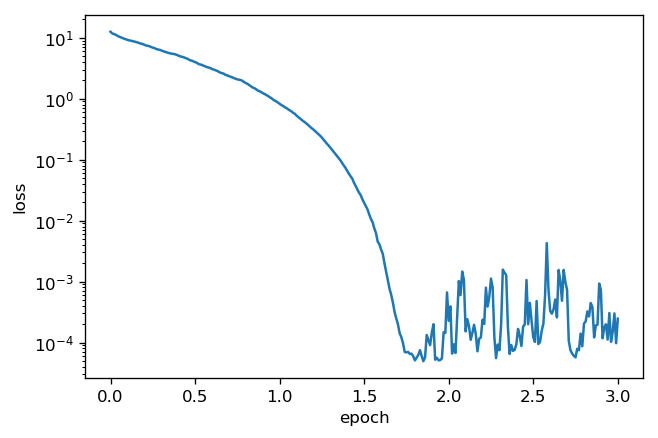

In [4]:
train(batch_size=10, lr=0.03, gamma=0.9, epochs=3, period=10)

我们将gamma调大一点，例如0.999。这时损失函数在迭代后期较平滑。

Batch size 10, Learning rate 0.030000, Epoch 1, loss 4.9290e-05


Batch size 10, Learning rate 0.030000, Epoch 2, loss 4.8610e-05


Batch size 10, Learning rate 0.030000, Epoch 3, loss 5.0128e-05
w: [[ 1.99884903 -3.39923334]] b: 4.19947 



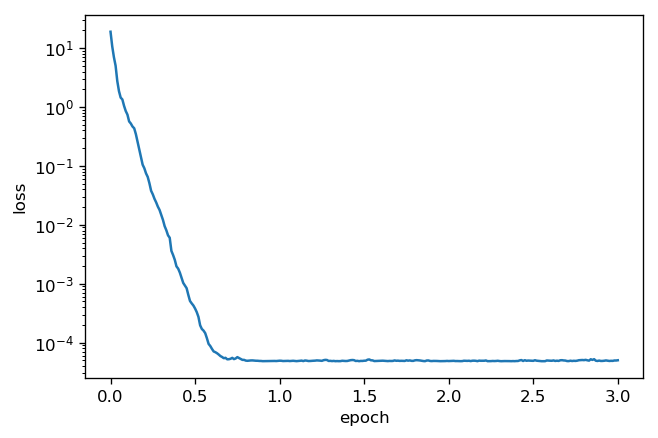

In [5]:
train(batch_size=10, lr=0.03, gamma=0.999, epochs=3, period=10)

## 结论

* RMSProp和Adagrad的不同在于，RMSProp使用了梯度按元素平方的指数加权移动平均变量来调整学习率。
* 通过调整指数加权移动平均中gamma参数的值可以控制学习率的变化。


## 练习

* 通过查阅网上资料，你对指数加权移动平均是怎样理解的？
* 为什么gamma调大后，损失函数在迭代后期较平滑？

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/2275)